# Árvores de Decisão

Nesta base vamos tentar predizer a temperatura máxima do dia seguinte em Seattle-WA baseado em dados climáticos

1. Carregue a base temps.csv e prepare os dados
    - Visualização, tratamento de colunas, divisão de dados, etc
2. Crie e treine uma Árvore de Decisão
    - Varie alguns parâmetros e avalie por meio de validação cruzada considerando que se trata de uma série temporal 
    - Obs.: por se tratar de uma série de dados temporal, existem algumas implicações na validação cruzada.
    - Favor ler [este link](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-of-time-series-data) e tentar se adaptar a este fator
3. Treine o modelo final e avalie-o na base de testes
    - Utilize os melhores parâmetros descobertos na etapa anterior, use o modelo para predizer a temperatura (actual) na base de testes e avalie o resultado
4. Exiba a árvore final em texto simples e como uma imagem
5. Extra: exiba a predição e os dados reais (eixo y) vs a data (eixo x)

### 1. Carregue a base temps.csv e prepare os dados

**Database Loading**

In [1]:
import pandas as pd

df = pd.read_csv('../data/temps.csv')

**Data Exploration**

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            348 non-null    int64  
 1   month           348 non-null    int64  
 2   day             348 non-null    int64  
 3   week            348 non-null    object 
 4   temp_2          348 non-null    int64  
 5   temp_1          348 non-null    int64  
 6   average         348 non-null    float64
 7   actual          348 non-null    int64  
 8   forecast_noaa   348 non-null    int64  
 9   forecast_acc    348 non-null    int64  
 10  forecast_under  348 non-null    int64  
 11  friend          348 non-null    int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 32.8+ KB


In [3]:
df.head()

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


In [4]:
df.describe()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


**Data Visualization**

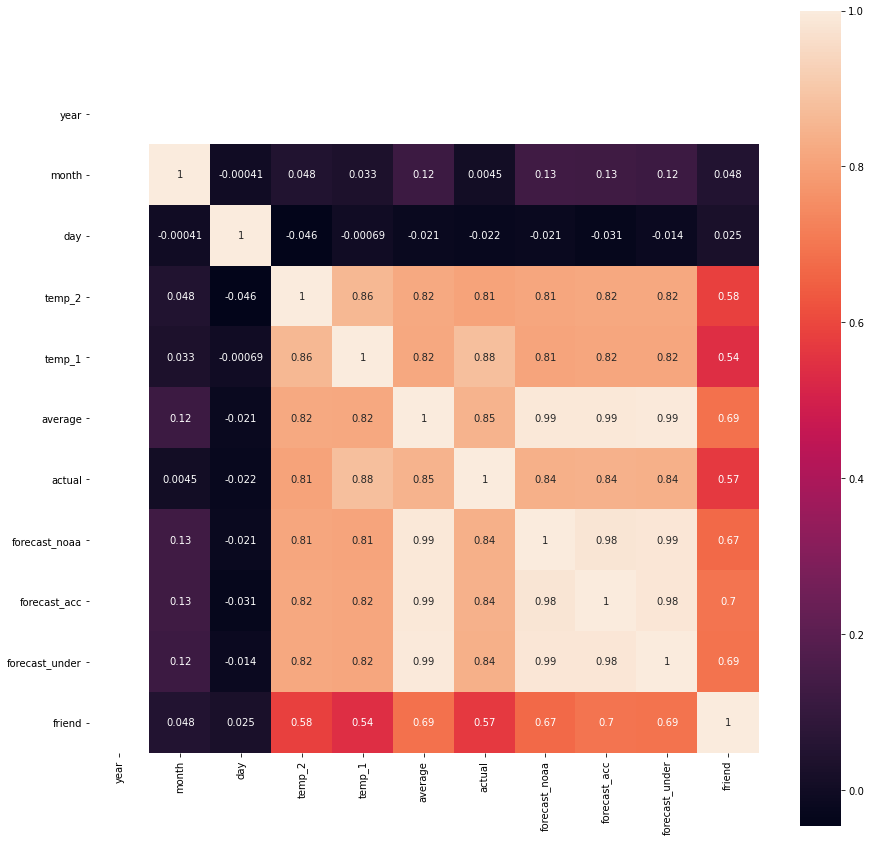

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# correlation matrix
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),
            annot=True,
            square=True)

In [ ]:
import seaborn as sns

# pairplot
features = df.loc[:, df.columns != 'actual']
sns.pairplot(df,
             vars=features)

**Data Handling**

In [ ]:
# convert categorical variables to numerical representations via one-hot coding on data.
df = pd.get_dummies(df)
df.info()

**Database Splitting**

In [ ]:
from sklearn.model_selection import train_test_split

y = df['actual']
X = df.drop(['actual'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42,
                                                    shuffle=False)

### 2. Crie e treine uma Árvore de Decisão

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

pipeline = Pipeline([#('scaler', StandardScaler()),
                     ('DTR', DecisionTreeRegressor(random_state=42))])

# Note on 'Pipeline': 
# when not using pipeline, scaled features used for
# CV are separated into test and train fold, but the
# test fold already contains the info about training
# set as the whole training set (X_train) was used 
# for standardization. In a simpler note when model.fit()
# is done using cross-validation the features already 
# include info from the test-fold as StandardScaler.fit()
# was done on the whole training set.
#
# This may be bypassed with pipeline: StandardScaler() and model()
# are glued together -- ensuring that during cross validation
# the StandardScaler is fitted to only the training fold, exactly
# similar fold used for model.fit() 
#
# Note on Normalization:
# decision trees work on data independently, not as a function
# like most other approaches. for this reason, the user is not
# obligated to normalize data. we aren't normalizing here, also
# to the preference of using the real data and that this dataset
# is quite balanced.
#
# source: https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976

**Varie alguns parâmetros e avalie por meio de validação cruzada considerando que se trata de uma série temporal**

In [10]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV

hyperparameters = {'DTR__criterion': ['mse', 'friedman_mse', 'mae'],
                   'DTR__splitter': ['best', 'random'],
                   'DTR__max_depth': [1, 5, 10, 20, 50, None],
                   'DTR__min_samples_split': [1, 5, 10, 20],
                   'DTR__min_samples_leaf': [1, 5, 10, 20, 50, 100],
                   'DTR__max_features': ['auto', 'sqrt', 'log2', None],
                   'DTR__max_leaf_nodes': [1, 5, 10, 20, 50, None]}

tscv = TimeSeriesSplit(max_train_size=None,
                       n_splits=10)

gscv  = GridSearchCV(pipeline, 
                     param_grid=hyperparameters, 
                     cv=tscv,
                     scoring='neg_root_mean_squared_error',
                     n_jobs=-1)

rscv  = RandomizedSearchCV(pipeline, 
                           param_distributions=hyperparameters,
                           cv=tscv,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1)

In [11]:
import json

gscv_result = gscv.fit(X_train, y_train)

print("GridSearchCV Best: ", gscv_result.best_score_)
print("Parameters:\n", json.dumps(gscv_result.best_params_, indent=2))

GridSearchCV Best:  -5.913908751152288
Parameters:
 {
  "DTR__criterion": "mse",
  "DTR__max_depth": 5,
  "DTR__max_features": "auto",
  "DTR__max_leaf_nodes": 5,
  "DTR__min_samples_leaf": 5,
  "DTR__min_samples_split": 20,
  "DTR__splitter": "best"
}


In [12]:
import json

rscv_result = rscv.fit(X_train, y_train)

print("RandomizedSearchCV Best: ", rscv_result.best_score_)
print("Parameters:\n", json.dumps(rscv_result.best_params_, indent=2))

RandomizedSearchCV Best:  -6.7513275814242615
Parameters:
 {
  "DTR__splitter": "random",
  "DTR__min_samples_split": 5,
  "DTR__min_samples_leaf": 10,
  "DTR__max_leaf_nodes": null,
  "DTR__max_features": null,
  "DTR__max_depth": 50,
  "DTR__criterion": "friedman_mse"
}


### 3. Treine o modelo final e avalie-o na base de testes

**Utilize os melhores parâmetros descobertos na etapa anterior, use o modelo para predizer a temperatura (actual) na base de testes**

In [13]:
y_pred = gscv.predict(X_test)

print(y_pred)

[72.46478873 72.46478873 72.46478873 72.46478873 72.46478873 72.46478873
 72.46478873 63.76190476 72.46478873 72.46478873 78.93333333 72.46478873
 72.46478873 63.76190476 72.46478873 63.76190476 63.76190476 63.76190476
 63.76190476 63.76190476 63.76190476 63.76190476 72.46478873 63.76190476
 63.76190476 63.76190476 63.76190476 63.76190476 63.76190476 63.76190476
 63.76190476 63.76190476 63.76190476 63.76190476 63.76190476 63.76190476
 63.76190476 63.76190476 63.76190476 63.76190476 63.76190476 63.76190476
 55.95744681 78.93333333 55.95744681 55.95744681 55.95744681 55.95744681
 55.95744681 55.95744681 55.95744681 55.95744681 72.46478873 55.95744681
 55.95744681 55.95744681 55.95744681 55.95744681 55.95744681 55.95744681
 55.95744681 55.95744681 55.95744681 55.95744681 55.95744681 55.95744681
 49.73684211 49.73684211 49.73684211 49.73684211 49.73684211 49.73684211
 49.73684211 49.73684211 49.73684211 49.73684211 49.73684211 49.73684211
 49.73684211 49.73684211 49.73684211 49.73684211 49

**Avaliação do resultado**

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, accuracy_score
import numpy as np

mae    = mean_absolute_error(y_test, y_pred)
mse    = mean_squared_error(y_test, y_pred)
rmse   = np.sqrt(mean_squared_error(y_test, y_pred))
r_sqrd = r2_score(y_test, y_pred)

print(f"Mean Absolute Error   : {mae:.2f}")
print(f"Mean Squared Error    : {mse:.2f}")
print(f"Root Mean Square Error: {rmse:.2f}")
print(f"R-Squared             : {r_sqrd:.2f}")

Mean Absolute Error   : 4.98
Mean Squared Error    : 40.87
Root Mean Square Error: 6.39
R-Squared             : 0.59


### 4. Exiba a árvore final em texto simples e como uma imagem

[Text(186.0, 190.26, 'X[4] <= 66.5\nmse = 128.341\nsamples = 243\nvalue = 65.412'),
 Text(111.60000000000001, 135.9, 'X[5] <= 55.55\nmse = 46.628\nsamples = 127\nvalue = 56.677'),
 Text(74.4, 81.53999999999999, 'X[5] <= 49.25\nmse = 23.698\nsamples = 85\nvalue = 53.176'),
 Text(37.2, 27.180000000000007, 'mse = 17.036\nsamples = 38\nvalue = 49.737'),
 Text(111.60000000000001, 27.180000000000007, 'mse = 11.785\nsamples = 47\nvalue = 55.957'),
 Text(148.8, 81.53999999999999, 'mse = 18.039\nsamples = 42\nvalue = 63.762'),
 Text(260.40000000000003, 135.9, 'X[4] <= 76.5\nmse = 42.836\nsamples = 116\nvalue = 74.974'),
 Text(223.20000000000002, 81.53999999999999, 'mse = 25.77\nsamples = 71\nvalue = 72.465'),
 Text(297.6, 81.53999999999999, 'mse = 44.151\nsamples = 45\nvalue = 78.933')]

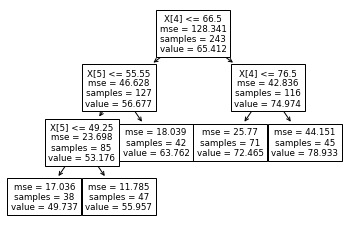

In [15]:
from sklearn import tree

tree.plot_tree(gscv.best_estimator_['DTR'])

### 5. Extra: exiba a predição e os dados reais (y) vs a data (x)

In [16]:
df_y_pred=pd.DataFrame(y_pred, columns=['y_pred'])
df_y_pred

,y_pred
0,72.464789
1,72.464789
2,72.464789
3,72.464789
4,72.464789
...,...
100,49.736842
101,49.736842
102,49.736842
103,49.736842


In [17]:
df_y=pd.DataFrame(y_test)
df_y

,actual
243,68
244,69
245,71
246,67
247,68
...,...
343,47
344,48
345,48
346,57


In [18]:
df_x=pd.DataFrame(X_test)
df_x

,year,month,day,temp_2,temp_1,average,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
243,2016,9,17,71,75,70.3,66,73,70,84,0,0,1,0,0,0,0
244,2016,9,18,75,68,70.0,66,73,71,90,0,0,0,1,0,0,0
245,2016,9,19,68,69,69.7,65,74,71,88,0,1,0,0,0,0,0
246,2016,9,20,69,71,69.4,67,73,69,81,0,0,0,0,0,1,0
247,2016,9,21,71,67,69.0,65,70,70,76,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,2016,12,27,42,42,45.2,41,50,47,47,0,0,0,0,0,1,0
344,2016,12,28,42,47,45.3,41,49,44,58,0,0,0,0,0,0,1
345,2016,12,29,47,48,45.3,43,50,45,65,0,0,0,0,1,0,0
346,2016,12,30,48,48,45.4,44,46,44,42,1,0,0,0,0,0,0
